# Анализ рентабельности рекламы приложения

## Введение

В работе проанализированы аудитория приложения и рентабельность рекламы для привлечения пользователей.  
В работе оценены LTV, CAC, ROI, DAU, MAU, RR.  
По результатам анализа сформулированы рекомендации для отдела маркетинга.

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

### Функции

In [2]:
def get_profiles(sessions, orders, ad_costs):
    """Создание пользовательских профилей
    
    :param sessions: датасет с посещениями
    :param orders: датасет с заказами
    :param ad_costs: датасет с инфо по рекламе
    :return: профили
    """
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )
    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles


In [3]:
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):
    """Расчёт удержания
    
    :param profiles: профили
    :param sessions: сессии
    :param observation_date: дата
    :param horizon_days: горизонт анализа
    :param dimensions: признаки
    :param ignore_horizon: игнорирование горизонта анализа
    :return: сырые данные, таблица удержания, таблица динамики удержания
    """
    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [4]:
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):
    """Расчёт конверсии
    
    :param profiles: профили
    :param purchases: покупки
    :param observation_date: дата наблюдения
    :param horizon_days: горизонт анализа в днях
    :param dimensions: признаки
    :param ignore_horizon: игнорирование горизонта анализа
    :return: сырые данные, таблица конверсии, таблица динамики конверсии
    """

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [5]:
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):
    """Расчёт LTV и ROI
    
    :param profiles: профили
    :param purchases: покупки
    :param observation_date: дата наблюдений
    :param horizon_days: горизонт анализа
    :param dimensions: признаки
    :param ignore_horizon: игнорирование горизонта анализа
    :return: tuple - (сырые данные, таблица LTV, таблица динамики LTV, таблица ROI, таблица динамики ROI)
    """
    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

In [6]:
def filter_data(df, window):
    """Сглаживание фрейма, скользящее среднее
    
    :param df: датафрейм
    :param window: параметры окна
    :return: сглаженный датафрейм
    """
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

In [7]:
def plot_retention(retention, retention_history, horizon, window=7):
    """Визуализация удержания
    
    :param retention: удержание
    :param retention_history: удержание
    :param horizon: горизонт анализа
    :param window: параметры окна для сглаживания
    :return: none
    """
    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания не платящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание не платящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в четвёртой ячейке — динамика удержания не платящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания не платящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

In [8]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):
    """Визуализация конверсии
        
    :param conversion: конверсия
    :param conversion_history: конверсия
    :param horizon: горизонт анализа
    :param window: параметры окна для сглаживания
    :return: none
    """
    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

In [9]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):
    """Визуализация LTV и ROI
    
    :param ltv: LTV
    :param ltv_history: LTV
    :param roi: ROI
    :param roi_history: ROI 
    :param horizon: горизонт анализа
    :param window: параметры окна для сглаживания
    :return: none
    """
    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

In [10]:
def change_col(df):
    """Приведение названий столбцов к snake_case
    
    :param df: датафрейм
    :return: none
    """
    cnames = []
    for i in range(len(df.columns)):
        cnames.append(df.columns[i].lower().replace(' ', '_'))
    df.columns = cnames

### Загрузка и подготовка данных

In [11]:
# Загрузка данных
try:
    visits, orders, costs = (
        pd.read_csv('visits_info_short.csv'),
        pd.read_csv('orders_info_short.csv'),
        pd.read_csv('costs_info_short.csv')
    )
except FileNotFoundError:
    visits, orders, costs = (
        pd.read_csv('/datasets/visits_info_short.csv'),
        pd.read_csv('/datasets/orders_info_short.csv'),
        pd.read_csv('/datasets/costs_info_short.csv')
    )

Посмотрим таблицы.

In [12]:
display(visits.head(5)), visits.info()

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
User Id          309901 non-null int64
Region           309901 non-null object
Device           309901 non-null object
Channel          309901 non-null object
Session Start    309901 non-null object
Session End      309901 non-null object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


(None, None)

In [13]:
display(orders.head(5)), orders.info()

,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
User Id     40212 non-null int64
Event Dt    40212 non-null object
Revenue     40212 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


(None, None)

In [14]:
display(costs.head(5)), costs.info()

,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
dt         1800 non-null object
Channel    1800 non-null object
costs      1800 non-null float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


(None, None)

Далее поправим названия столбцов, типы данных, проверим дубликаты.

#### Исправление названий столбцов

In [15]:
change_col(visits)
change_col(orders)
change_col(costs)

#### Изменение типов данных

Во всех таблицах даты приведём к datetime.

In [16]:
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

#### Проверка дубликатов

In [17]:
# проверка дубликатов
data = [visits, orders, costs]
visits.name = 'visits'
orders.name = 'orders'
costs.name ='costs'
for frame in data:
    dbl = frame[frame.duplicated()][frame.columns[0]].count()
    print(f'Дубликатов в таблице {frame.name}: {dbl}.')

Дубликатов в таблице visits: 0.
Дубликатов в таблице orders: 0.
Дубликатов в таблице costs: 0.


#### Просмотр уникальных значений

Проверим уникальные значения по категориальным полям в каждой таблице.

In [18]:
for col in ['region', 'device', 'channel']:
    print(visits[col].sort_values().unique())
    print('==================================')

['France' 'Germany' 'UK' 'United States']
['Android' 'Mac' 'PC' 'iPhone']
['AdNonSense' 'FaceBoom' 'LeapBob' 'MediaTornado' 'OppleCreativeMedia'
 'RocketSuperAds' 'TipTop' 'WahooNetBanner' 'YRabbit' 'lambdaMediaAds'
 'organic']


In [19]:
print(costs['channel'].sort_values().unique())

['AdNonSense' 'FaceBoom' 'LeapBob' 'MediaTornado' 'OppleCreativeMedia'
 'RocketSuperAds' 'TipTop' 'WahooNetBanner' 'YRabbit' 'lambdaMediaAds']


Сравним каналы в `visits` и `costs`.

In [20]:
print(set(visits['channel'].unique()) - set(costs['channel'].unique()))

{'organic'}


Уникальные каналы в таблице с сессиями и затратами одни и те же, отличие только в органике, затраты на которую не посчитать.

## Исследовательский анализ данных

В разделе исследованы клиенты приложения.<br>
Рассмотрено, какими устройствами пользуются клиенты, из каких они регионов и какие каналы привели их в приложение.

### Пользовательские профили

In [21]:
profiles = get_profiles(visits, orders, costs)
display(profiles.head()), profiles.info()

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


<class 'pandas.core.frame.DataFrame'>
Int64Index: 150008 entries, 0 to 150007
Data columns (total 9 columns):
user_id             150008 non-null int64
first_ts            150008 non-null datetime64[ns]
channel             150008 non-null object
device              150008 non-null object
region              150008 non-null object
dt                  150008 non-null object
month               150008 non-null datetime64[ns]
payer               150008 non-null bool
acquisition_cost    150008 non-null float64
dtypes: bool(1), datetime64[ns](2), float64(1), int64(1), object(4)
memory usage: 10.4+ MB


(None, None)

In [22]:
print('Максимальная дата привлечения пользователей: {}'.format(profiles['first_ts'].dt.date.max()))
print('Минимальная дата привлечения пользователей: {}'.format(profiles['first_ts'].dt.date.min()))

Максимальная дата привлечения пользователей: 2019-10-27
Минимальная дата привлечения пользователей: 2019-05-01


### Пользователи по регионам

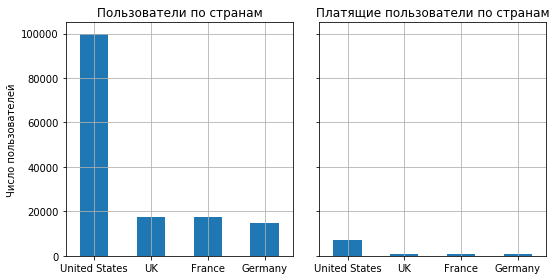

In [23]:
# Платящие пользователи по странам
plt.figure(figsize=(8, 4))

ax1 = plt.subplot(1, 2, 1)
(
    profiles
    .groupby('region').agg({'user_id' :'count'})
    .sort_values(by='user_id', ascending=False)
    .rename(columns={'user_id': 'paying_users'})
    .plot(kind='bar', grid=True, legend=False, ax=ax1)
)
plt.title('Пользователи по странам')
plt.ylabel('Число пользователей')
plt.xlabel('')
plt.xticks(rotation = 0)

ax2 = plt.subplot(1, 2, 2, sharey = ax1)
(
     profiles.query('payer == True')
    .groupby('region').agg({'user_id' :'count'})
    .sort_values(by='user_id', ascending=False)
    .rename(columns={'user_id': 'paying_users'})
    .plot(kind='bar', grid=True, legend=False, ax=ax2)
)
plt.title('Платящие пользователи по странам')
plt.ylabel('Число пользователей')
plt.xlabel('')
plt.xticks(rotation = 0)

plt.tight_layout()
plt.show()

In [24]:
# доля платящих пользователей
countries = (
    profiles.groupby('region').agg({'user_id': 'count'})
    .merge(
        profiles.query('payer == True').groupby('region').agg({'user_id': 'count'}),
        on='region',
        how='left'
    )
)
countries.columns=['all_users', 'paying_users']
countries['conversion, %'] = round(countries['paying_users'] / countries['all_users'] * 100, 2)
countries['share_of_paying_users, %'] = round(countries['paying_users'] / countries['paying_users'].sum()  * 100, 2)
countries = countries.sort_values(by='paying_users', ascending=False)
countries

,all_users,paying_users,"conversion, %","share_of_paying_users, %"
region,,,,
United States,100002,6902,6.90,77.72
UK,17575,700,3.98,7.88
France,17450,663,3.80,7.47
Germany,14981,616,4.11,6.94


Больше всего платящих пользователей в США, 77.72% от всех платящих.<br>
Конверсия посетителей в покупателей также самая высокая в США, 6.90%.

### Пользователи по устройствам

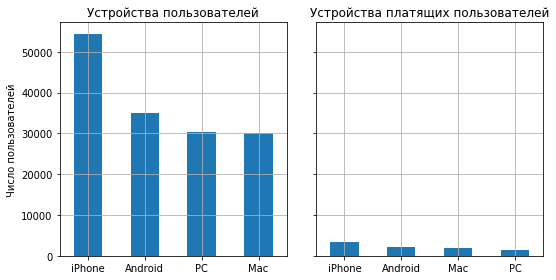

In [25]:
# Платящие пользователи по устройствам
plt.figure(figsize=(8, 4))

ax1 = plt.subplot(1, 2, 1)
(
    profiles
    .groupby('device').agg({'user_id' :'count'})
    .sort_values(by='user_id', ascending=False)
    .rename(columns={'user_id': 'paying_users'})
    .plot(kind='bar', grid=True, legend=False, ax=ax1)
)
plt.title('Устройства пользователей')
plt.ylabel('Число пользователей')
plt.xlabel('')
plt.xticks(rotation = 0)

ax2 = plt.subplot(1, 2, 2, sharey = ax1)
(
     profiles.query('payer == True')
    .groupby('device').agg({'user_id' :'count'})
    .sort_values(by='user_id', ascending=False)
    .rename(columns={'user_id': 'paying_users'})
    .plot(kind='bar', grid=True, legend=False, ax=ax2)
)
plt.title('Устройства платящих пользователей')
plt.ylabel('Число пользователей')
plt.xlabel('')
plt.xticks(rotation = 0)

plt.tight_layout()
plt.show()

In [26]:
# доля платящих пользователей
devices = (
    profiles.groupby('device').agg({'user_id': 'count'})
    .merge(
        profiles.query('payer == True').groupby('device').agg({'user_id': 'count'}),
        on='device',
        how='left'
    )
)
devices.columns=['all_users', 'paying_users']
devices['conversion, %'] = round(devices['paying_users'] / devices['all_users'] * 100, 2)
devices['share_of_paying_users, %'] = round(devices['paying_users'] / devices['paying_users'].sum()  * 100, 2)
devices = devices.sort_values(by='paying_users', ascending=False)
devices

,all_users,paying_users,"conversion, %","share_of_paying_users, %"
device,,,,
iPhone,54479,3382,6.21,38.08
Android,35032,2050,5.85,23.08
Mac,30042,1912,6.36,21.53
PC,30455,1537,5.05,17.31


Больше всего платящих пользователей с iPhone.<br>
Конверсия в покупателей у яблочной экосистемы выше, чем у PC + Android.

### Каналы

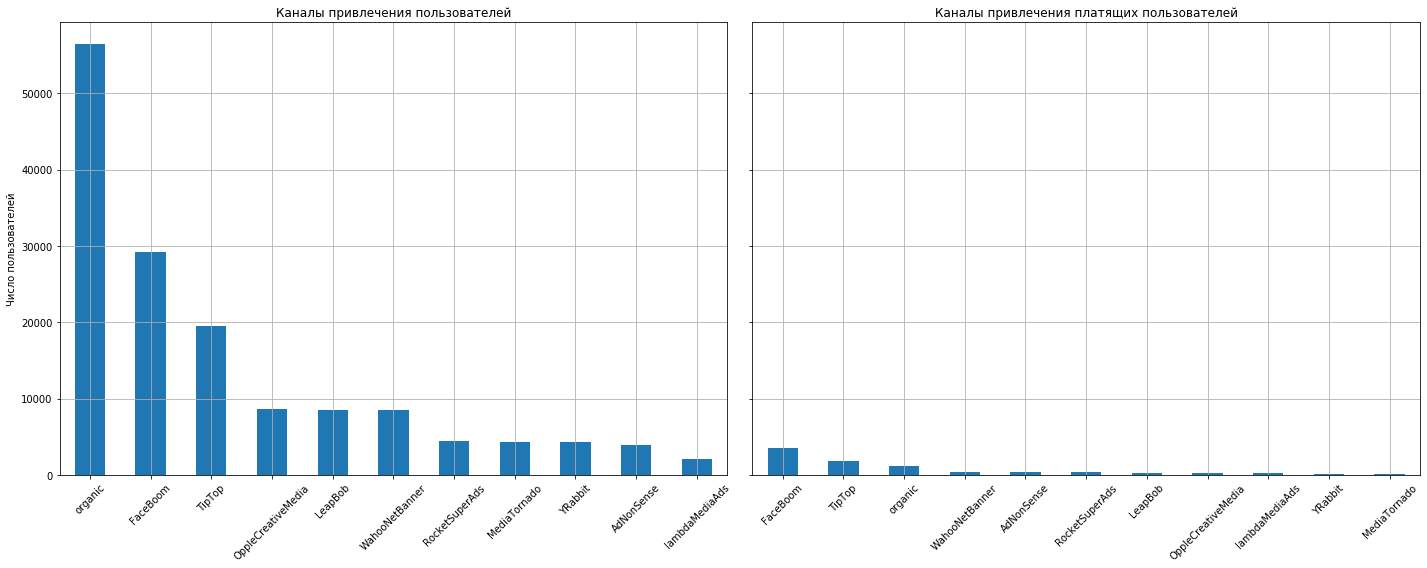

In [27]:
# Каналы привлечения пользователей
plt.figure(figsize=(20, 8))

ax1 = plt.subplot(1, 2, 1)
(
    profiles
    .groupby('channel').agg({'user_id' :'count'})
    .sort_values(by='user_id', ascending=False)
    .rename(columns={'user_id': 'paying_users'})
    .plot(kind='bar', grid=True, legend=False, ax=ax1)
)
plt.title('Каналы привлечения пользователей')
plt.ylabel('Число пользователей')
plt.xlabel('')
plt.xticks(rotation = 45)

ax2 = plt.subplot(1, 2, 2, sharey = ax1)
(
     profiles.query('payer == True')
    .groupby('channel').agg({'user_id' :'count'})
    .sort_values(by='user_id', ascending=False)
    .rename(columns={'user_id': 'paying_users'})
    .plot(kind='bar', grid=True, legend=False, ax=ax2)
)
plt.title('Каналы привлечения платящих пользователей')
plt.ylabel('Число пользователей')
plt.xlabel('')
plt.xticks(rotation = 45)

plt.tight_layout()
plt.show()

In [28]:
# доля платящих пользователей по каналам
channels = (
    profiles.groupby('channel').agg({'user_id': 'count'})
    .merge(
        profiles.query('payer == True').groupby('channel').agg({'user_id': 'count'}),
        on='channel',
        how='left'
    )
)
channels.columns=['all_users', 'paying_users']
channels['conversion, %'] = round(channels['paying_users'] / channels['all_users'] * 100, 2)
channels['share_of_paying_users, %'] = round(channels['paying_users'] / channels['paying_users'].sum()  * 100, 2)
channels = channels.sort_values(by='paying_users', ascending=False)
channels

,all_users,paying_users,"conversion, %","share_of_paying_users, %"
channel,,,,
FaceBoom,29144,3557,12.20,40.05
TipTop,19561,1878,9.60,21.15
organic,56439,1160,2.06,13.06
WahooNetBanner,8553,453,5.30,5.10
AdNonSense,3880,440,11.34,4.95
RocketSuperAds,4448,352,7.91,3.96
LeapBob,8553,262,3.06,2.95
OppleCreativeMedia,8605,233,2.71,2.62
lambdaMediaAds,2149,225,10.47,2.53


`FaceBoom` и `TipTop` работают круто. Трафик от этих каналов сопоставим с органикой по всем регионам.<br>
Посмотрим подробнее.

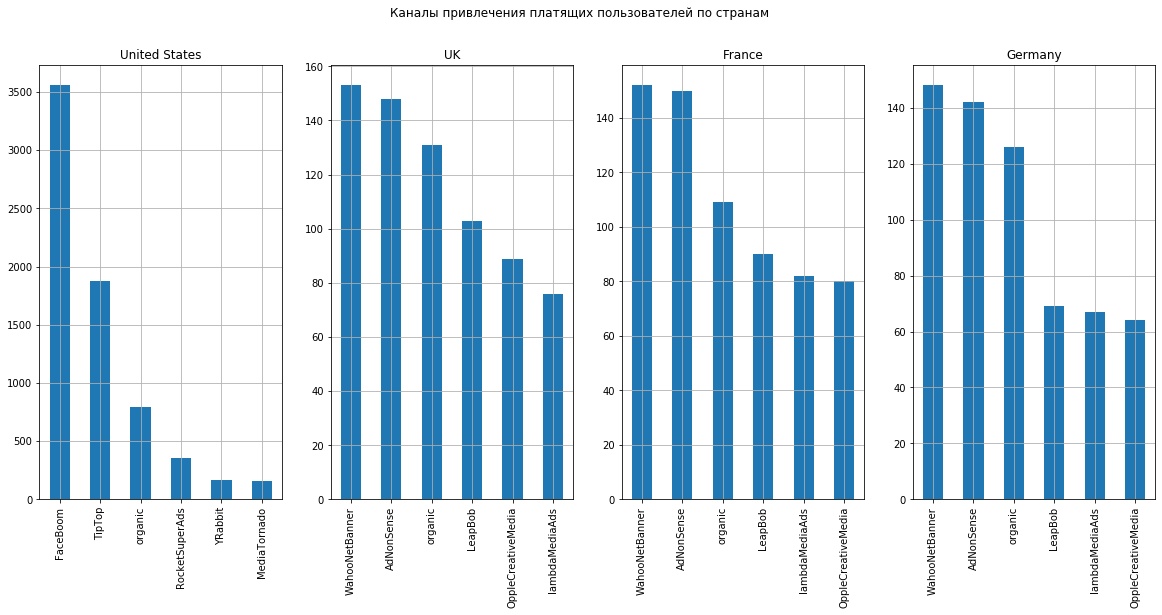

In [29]:
# каналы привлечения платящих пользователей по странам
plt.figure(figsize=(20,8))
plt.suptitle('Каналы привлечения платящих пользователей по странам')
for i, reg in enumerate(list(countries.index)):
    (
        # выбираем из профилей платящих пользователей из одного региона
        profiles.query('payer == True and region == @reg') 
        .groupby('channel').agg({'user_id' :'count'})
        .sort_values(by='user_id', ascending=False)
        .rename(columns={'user_id': 'paying_users'})
        .plot(kind='bar', grid=True, legend=False, ax=plt.subplot(1, 4, i + 1))
    )
    plt.title('{}'.format(reg))
    plt.xlabel('')
    plt.xticks(rotation = 90)

plt.show()

Из графиков видно, что на рынках Европы лучшие каналы — `WahooNetBanner` и `AdNonSense`.

### Вывод по разделу

Лучше всего платят пользователи из `США`.<br>
По платформам самые прибыльные `iPhone` для мобильных, `Mac` для стационарных. 

Лучшие каналы Европы — `WahooNetBanner` и `AdNonSense`. <br>
Лучшие каналы в США — `FaceBoom` и `TipTop`.<br>
`FaceBoom` подозрительно хорош.

## Маркетинг

### Расходы на маркетинг

In [30]:
# общая сумма расходов на маркетинг
print('Общая сумма расходов на маркетинг: {}.'.format(profiles['acquisition_cost'].sum().astype(int)))

Общая сумма расходов на маркетинг: 105497.


In [31]:
# расходы на маркетинг по странам
mcosts = (
    profiles.groupby('region')
    .agg({
        'acquisition_cost': 'sum'
    })
    .rename(columns={
        'acquisition_cost': 'marketing_costs'
    })
    .sort_values(by='marketing_costs', ascending=False)
)
mcosts['marketing_costs'] = mcosts['marketing_costs'].astype(int)
mcosts

,marketing_costs
region,
United States,90928
France,5075
UK,5068
Germany,4424


Расходы по странам распределены так же, как и число пользователей.

In [32]:
# расходы на маркетинг по каналам
mcosts = (
    profiles.groupby('channel')
    .agg({
        'acquisition_cost': 'sum'
    })
    .rename(columns={
        'acquisition_cost': 'marketing_costs'
    })
    .sort_values(by='marketing_costs', ascending=False)
)
mcosts['marketing_costs'] = mcosts['marketing_costs'].astype(int)
mcosts

,marketing_costs
channel,
TipTop,54751
FaceBoom,32445
WahooNetBanner,5151
AdNonSense,3911
OppleCreativeMedia,2151
RocketSuperAds,1833
LeapBob,1797
lambdaMediaAds,1557
MediaTornado,954


Расходы на маркетинг по каналам тоже не отличаются от числа привлечённых пользователей.<br>
Впереди те же компании: `TipTop`, `FaceBoom`, `WahooNetBanner`, `AdNonSense`.<br>

### CAC по каналу

In [33]:
# Расходы на привлечение одного пользователя
cac_all = (
    round(profiles['acquisition_cost'].mean(), 2)
)
print(f'Расходы на привлечение одного пользователя по всему проекту: {cac_all}')

Расходы на привлечение одного пользователя по всему проекту: 0.7


In [34]:
# Расходы на привлечение одного пользователя
# Органически привлечённые пользователи исключены из выборки
cac_no_org = (
    round(profiles.query('channel != "organic"')['acquisition_cost'].mean(), 2)
)
print(f'Расходы на привлечение одного пользователя по всему проекту, без органики: {cac_no_org}')

Расходы на привлечение одного пользователя по всему проекту, без органики: 1.13


In [35]:
<a id='cac_per_channel'></a>

SyntaxError: invalid syntax (3993092607.py, line 1)

In [ ]:
# Расходы на привлечение одного пользователя по каналу
(
    profiles.groupby('channel')
    .agg({'acquisition_cost': 'mean'})
    .rename(columns={'acquisition_cost': 'cac'})
    .sort_values(by='cac', ascending=False)
)

In [ ]:
# Расходы на привлечение одного пользователя по каналу
(
    profiles.groupby('channel')
    .agg({'acquisition_cost': 'mean'})
    .rename(columns={'acquisition_cost': 'cac'})
    .sort_values(by='cac', ascending=False)
    .plot(kind='bar', grid=True, legend=False)
)
plt.show()

### Вывод по разделу

Самая высокая стоимость привлечения пользователей у `TipTop`.<br>
При этом конверсия в покупателей и процент платящих пользователей в топе лучших.<br>
На данном этапе можно предположить, что средний чек у аудитории TipTop сильно ниже среднего чека аудитории остальных каналов привлечения пользователей.

## Оценка окупаемости

### Окупаемость рекламы

#### Окупаемость без разбивки

Согласно условию установим момент анализа 01 ноября 2019 года с горизонтом в 14 дней.<br>
Органику исключим из рассмотрения, т.к. точно не определить влияние вложений в остальные каналы на привлечение через органику.<br>
Но помним, что оптимизацией поисковой выдачи тоже занимается маркетинг.

<a id='roi_for_all'></a>

In [ ]:
# момент анализа
observation_date = datetime(2019, 11, 1).date()

# горизонт анализа
horizon_days = 14

# исключаем органику из анализа
profiles_no_org = profiles.query('channel != "organic"')

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_no_org,
    orders,
    observation_date,
    horizon_days
)
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

По графикам можно сказать следующее:<br>
- средний LTV к 14 дню порядка 0.9$;
- LTV колеблется с периодичностью в месяц;
- затраты на не окупаются, ROI около 80%;
- стоимость привлечения пользователей равномерно растёт.

#### Окупаемость рекламы с разбивкой по странам

<a id='roi_countries'></a>

In [ ]:
# разбивка по странам
dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_no_org, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Промежуточные выводы:<br>
- больше всего денег выручается в США;
- стоимость привлечения пользователей в США повышается с июня, когда в остальных странах падает с этого же месяца;
- реклама не окупается в США.

#### Окупаемость рекламы с разбивкой по каналам

<a id='roi_channels'></a>

In [ ]:
# разбивка по каналам
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_no_org, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Промежуточные выводы:<br>
- стоимость привлечения пользователей `TipTop` резко возрастает с июня;<br>
- стоимость привлечения пользователей по остальным каналам постоянна;<br>
- не окупаются `FaceBoom`, `TipTop` и `AdNonSense`.

#### Окупаемость рекламы с разбивкой по устройствам

<a id='devices'></a>

In [ ]:
# разбивка по устройствам
dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_no_org, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Промежуточные выводы:<br>
- привлечение пользователей для экосистемы apple сомое дорогое и растёт с июня сильнее других устройств;<br>
- окупается реклама для PC;<br>
- окупаемость по всем устройствам снижается.

### Конверсия и удержание

Далее построим графики конверсии и удержания с разбивкой по устройствам, странам, рекламным каналам.<br>
И ответим на вопросы:<br>
- Окупается ли реклама в целом?<br>
- Какие устройства, страны и каналы могут снижать окупаемость рекламы?<br>
- Чем могут быть вызваны проблемы окупаемости?<br>

#### Конверсия и удержание с разбивкой по странам

In [ ]:
# Конверсия с разбивкой по странам
dimensions = ['region']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_no_org, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

In [ ]:
# Удержание с разбивкой по странам
retention_raw, retention_grouped, retention_history = get_retention(
    profiles_no_org, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

Промежуточные выводы:<br>
- лучшая конверсия в США;
- удержание платящих пользователей хуже всего в США.

#### Конверсия и удержание с разбивкой по каналам

In [ ]:
# Конверсия с разбивкой по каналам
dimensions = ['channel']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_no_org, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

In [ ]:
# Удержание с разбивкой по каналам
retention_raw, retention_grouped, retention_history = get_retention(
    profiles_no_org, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

Промежуточные выводы:<br>
- худшее удержание у каналов `FaceBoom` и `AdNonSence`, они сильно выбиваются из остальной картины.

#### Конверсия и удержание с разбивкой по устройствам

In [ ]:
# Конверсия с разбивкой по устройствам
dimensions = ['device']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_no_org, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

In [ ]:
# Удержание с разбивкой по устройствам
retention_raw, retention_grouped, retention_history = get_retention(
    profiles_no_org, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

Промежуточные выводы:<br>
- конверсия для всех устройств стабильна, самая низкая конверсия у пользователей PC;<br>
- удержание для всех устройств примерно одинаково.

### Анализ каналов США

In [ ]:
profiles_usa = profiles_no_org.query('region == "United States"')

In [ ]:
# разбивка по каналам только для США
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_usa, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

In [ ]:
# Конверсия с разбивкой по каналам
dimensions = ['channel']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_usa, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

In [ ]:
# Удержание с разбивкой по каналам
retention_raw, retention_grouped, retention_history = get_retention(
    profiles_usa, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

Выводы по каналам США:<br>
- TipTop
    - хорошая конверсия;
    - стоимость привлечения пользователей сильно растёт;
    - высокий LTV;
    - не рентабелен.
- FaceBoom
    - лучшая конверсия пользователей;
    - проблемы с удержанием платящих пользователей;
    - не рентабелен.
- RocketSuperAds
    - 3й по конверсии;
    - стоимость привлечения пользователей немного снижается;
    - с удержанием платящих пользователей всё хорошо;
    - <b>рентабелен</b>.


### Вывод по разделу

Ответы на поставленные вопросы:<br>
- Окупается ли реклама в целом?<br>
[Не окупается](#roi_for_all), ROI около 80%.<br>
- Какие устройства, страны и каналы могут снижать окупаемость рекламы?<br>
Устройства: [iPhone, Mac, Android](#roi_devices), окупается только PC.<br>
Каналы: [FaceBoom, TipTop и AdNonSense](#roi_channels).<br>
Страны: [США](#roi_countries).<br>
- Чем могут быть вызваны проблемы окупаемости?  
Вероятнее всего проблемы окупаемости вызваны стоимостью привлечения пользователей.<br>
Подробнее: [средние значения](#cac_per_channel) за весть период по каналу, [динамика](#roi_for_all) стоимости привлечения пользователей.<br>


## Общий вывод

Инвестиции в каналы `FaceBoom`, `TipTop` и `AdNonSense` не рентабельны.<br>

Рекомендации для отдела маркетинга.
- Проанализировать аудиторию США, платформ `FaceBoom`, `TipTop`.
- Перераспределить инвестиции, часть бюджета отдать каналам с платёжеспособной аудиторией (например, оценить средний чек,  число покупок).
- На рынке США часть средств стоит перенаправить в `RocketSuperAds`.<br>
Это рентабельный канал с отличными конверсией и удержанием платящих пользователей.